# 1. Setup Environment

In [ ]:
# =============================================
# Standard Library Imports
# =============================================
import io
import time

# =============================================
# Third-Party Imports
# =============================================
# Numerical Computing
import numpy as np

# Computer Vision
import cv2
from PIL import Image

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    Dropout,
    Flatten
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping
)

# Jupyter/Colab Specific
from IPython.display import display, Javascript, HTML
from google.colab.output import eval_js
from base64 import b64decode, b64encode

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install required libraries
!pip install tensorflow opencv-python matplotlib numpy

# 1.1 Parameters

In [ ]:
# Define parameters
IMG_SIZE = (48, 48)
BATCH_SIZE = 32

EPOCHS=20

# 2. Setup Kaggle API and Download Dataset

---



In [ ]:
# Setup Kaggle API
from google.colab import files
files.upload()  # Upload your kaggle.json file

# Move Kaggle API key to proper location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download FER2013 dataset
!kaggle datasets download -d msambare/fer2013

# Unzip dataset
!unzip fer2013.zip -d fer2013

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: fer2013/train/sad/Training_65242339.jpg  
  inflating: fer2013/train/sad/Training_65267116.jpg  
  inflating: fer2013/train/sad/Training_65275626.jpg  
  inflating: fer2013/train/sad/Training_6529266.jpg  
  inflating: fer2013/train/sad/Training_65329617.jpg  
  inflating: fer2013/train/sad/Training_65338712.jpg  
  inflating: fer2013/train/sad/Training_65338797.jpg  
  inflating: fer2013/train/sad/Training_65387162.jpg  
  inflating: fer2013/train/sad/Training_65404494.jpg  
  inflating: fer2013/train/sad/Training_65426218.jpg  
  inflating: fer2013/train/sad/Training_65430136.jpg  
  inflating: fer2013/train/sad/Training_65437377.jpg  
  inflating: fer2013/train/sad/Training_6545735.jpg  
  inflating: fer2013/train/sad/Training_65463385.jpg  
  inflating: fer2013/train/sad/Training_65473985.jpg  
  inflating: fer2013/train/sad/Training_65502829.jpg  
  inflating: fer2013/train/sad/Training_6550

# 3. Preprocess Data

In [ ]:
# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    'fer2013/train',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'fer2013/train',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Class labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


# 4. Build CNN Model

In [ ]:
model = Sequential()

# First CNN layer
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

# Second CNN layer
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

# Third CNN layer
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 5. Train Model

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop]
)

# Save final model to Drive
model.save('/content/drive/MyDrive/emotion_model.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3481 - loss: 1.6465

718/718 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - accuracy: 0.3481 - loss: 1.6464 - val_accuracy: 0.4146 - val_loss: 1.5243
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4047 - loss: 1.5346

718/718 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.4047 - loss: 1.5346 - val_accuracy: 0.4459 - val_loss: 1.4362
Epoch 3/20
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4329 - loss: 1.4714

718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.4329 - loss: 1.4713 - val_accuracy: 0.4491 - val_loss: 1.4093
Epoch 4/20
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4512 - loss: 1.4311

718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.4512 - loss: 1.4311 - val_accuracy: 0.4759 - val_loss: 1.3641
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4626 - loss: 1.3891

718/718 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.4626 - loss: 1.3891 - val_accuracy: 0.4849 - val_loss: 1.3387
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4723 - loss: 1.3804

718/718 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.4723 - loss: 1.3804 - val_accuracy: 0.5072 - val_loss: 1.3083
Epoch 7/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4775 - loss: 1.3534

718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.4775 - loss: 1.3534 - val_accuracy: 0.5090 - val_loss: 1.3024
Epoch 8/20
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4826 - loss: 1.3405

718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.4826 - loss: 1.3406 - val_accuracy: 0.5132 - val_loss: 1.2852
Epoch 9/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4885 - loss: 1.3231

718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.4885 - loss: 1.3231 - val_accuracy: 0.5208 - val_loss: 1.2623
Epoch 10/20
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5022 - loss: 1.3135

718/718 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.5022 - loss: 1.3135 - val_accuracy: 0.5234 - val_loss: 1.2480
Epoch 11/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.5043 - loss: 1.3036 - val_accuracy: 0.5203 - val_loss: 1.2618
Epoch 12/20
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5089 - loss: 1.2930

718/718 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.5089 - loss: 1.2930 - val_accuracy: 0.5300 - val_loss: 1.2290
Epoch 13/20
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5048 - loss: 1.3027

718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.5048 - loss: 1.3027 - val_accuracy: 0.5393 - val_loss: 1.2169
Epoch 14/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.5114 - loss: 1.2800 - val_accuracy: 0.5360 - val_loss: 1.2152
Epoch 15/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.5100 - loss: 1.2930 - val_accuracy: 0.5290 - val_loss: 1.2321
Epoch 16/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.5178 - loss: 1.2715 - val_accuracy: 0.5393 - val_loss: 1.2084
Epoch 17/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.5125 - loss: 1.2750 - val_accuracy: 0.5388 - val_loss: 1.2340
Epoch 18/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.5212 - loss: 1.2571 - val_accuracy: 0.5344 - val_loss: 1.2239
Epoch 19/20
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5248 - loss: 1.2579

718/718 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.5248 - loss: 1.2579 - val_accuracy: 0.5464 - val_loss: 1.1921
Epoch 20/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.5240 - loss: 1.2635 - val_accuracy: 0.5363 - val_loss: 1.2132


# 6. Real-Time Emotion Detection

<IPython.core.display.Javascript object>


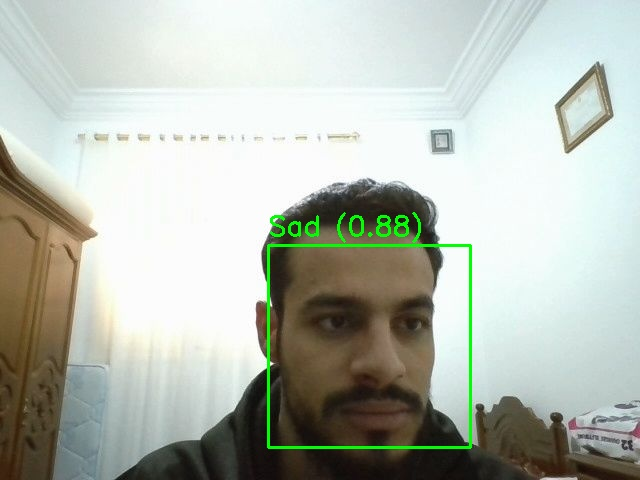

Starting emotion detection... Press 'Stop' in Colab to exit
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

KeyboardInterrupt: 

In [28]:
# Load your saved model (ignore the warning - it's harmless)
model_path = '/content/drive/MyDrive/emotion_model.h5'
model = tf.keras.models.load_model(model_path)

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# JavaScript to create webcam stream
js = Javascript('''
    async function setupWebcam() {
        const video = document.createElement('video');
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;
        await video.play();

        // Set video size
        video.width = 640;
        video.height = 480;

        // Create canvas for capturing
        const canvas = document.createElement('canvas');
        canvas.width = video.width;
        canvas.height = video.height;

        // Append to document
        document.body.appendChild(video);
        document.body.appendChild(canvas);

        return {'video': true};
    }
''')

# Display JavaScript and setup webcam
display(js)
eval_js('setupWebcam()')

# Function to get frame from webcam
def get_frame():
    # JavaScript to capture frame and return as base64
    frame_data = eval_js('''
        async function capture() {
            const video = document.querySelector('video');
            const canvas = document.querySelector('canvas');
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            return canvas.toDataURL('image/jpeg', 0.8);
        }
        capture();
    ''')

    # Convert base64 to OpenCV image
    header, encoded = frame_data.split(",", 1)
    binary = b64decode(encoded)
    image = Image.open(io.BytesIO(binary))
    frame = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    return frame

# Function to process frame
def process_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)

    for (x, y, w, h) in faces:
        try:
            roi_gray = gray[y:y+h, x:x+w]
            roi = cv2.resize(roi_gray, (48, 48))
            roi = roi.astype('float') / 255.0
            roi = np.expand_dims(roi, axis=-1)
            roi = np.expand_dims(roi, axis=0)

            prediction = model.predict(roi)[0]
            label = emotion_labels[np.argmax(prediction)]
            confidence = np.max(prediction)

            color = (0, 255, 0)
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
            cv2.putText(frame, f"{label} ({confidence:.2f})",
                       (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                       0.9, color, 2)
        except Exception as e:
            print(f"Error processing face: {e}")

    return frame

# Main loop
output = display(display_id=True)
print("Starting emotion detection... Press 'Stop' in Colab to exit")

try:
    while True:
        frame = get_frame()
        processed_frame = process_frame(frame)

        # Convert back to base64 for display
        _, buffer = cv2.imencode('.jpg', processed_frame)
        frame_b64 = b64encode(buffer).decode('utf-8')

        output.update(HTML(f"""
            <img src="data:image/jpeg;base64,{frame_b64}"
                 style="max-width: 640px; max-height: 480px">
        """))
        time.sleep(0.05)

except Exception as e:
    print(f"Stopped: {e}")
finally:
    # Clean up
    eval_js('''
        const video = document.querySelector('video');
        if (video && video.srcObject) {
            video.srcObject.getTracks().forEach(track => track.stop());
        }
    ''')
    print("Video capture stopped")